In [1]:
from tg.grammar_ru.common import *
from tg.projects.alternative import BundleBuilder, BundleConfig
from tg.projects.alternative import EndingNegativeSampler
from tg.grammar_ru import features as fe

tsa_sampler = EndingNegativeSampler('тся','ться')


config = BundleConfig(
    [
        Loc.corpus_path/'pub.base.zip',
        Loc.corpus_path/'books.base.zip',
        Loc.corpus_path/'lenta.base.zip'
    ],
    None,
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
        fe.SlovnetFeaturizer(),
        fe.SyntaxTreeFeaturizer(),
        fe.SyntaxStatsFeaturizer()
        
    ],
    Loc.temp_path/'tsa/',
)

builder = BundleBuilder(config)

In [2]:
from typing import *
import pandas as pd
from tg.grammar_ru.algorithms import SpellcheckAlgorithm
import numpy as np
from yo_fluq_ds import *


def _count_verbs(dfs: Iterable[pd.DataFrame]):
    counter = {}
    for df in dfs:
        df = df.loc[df.word.str.endswith('тся') | df.word.str.endswith('ться')]
        for word in df.word.str.lower():
            counter[word] = counter.get(word,0)+1
    return counter


def _another(w):
    if w.endswith('тся'):
        return w.replace('тся', 'ться')
    else:
        return w.replace('ться', 'тся')


def _get_good_words_df(words):
    for w in list(words):
        if _another(w) not in words:
            words[_another(w)] = 0

    rows = []
    for w in words:
        if w.endswith('ться'):
            rows.append((w,_another(w),words[w], words[_another(w)]))

    df = pd.DataFrame(rows, columns=['i_word','f_word','i_cnt','f_cnt'])
    df['both_found'] = df[['i_cnt','f_cnt']].min(axis=1)>0
    df = df[df.both_found]
    df['ratio'] = np.minimum(df.i_cnt/df.f_cnt, df.f_cnt/df.i_cnt)

    alg = SpellcheckAlgorithm()
    for prefix in ['i_', 'f_']:
        xdf = pd.DataFrame(dict(word=df[prefix+'word'], word_type='ru'))
        kdf = alg.run(DataBundle(src=xdf))
        df[prefix+'spell'] = ~kdf.error

    df['both_correct'] = df.i_spell & df.f_spell
    df = df.loc[df.both_correct]
    return df


def build_dictionary(dfs):
    cnt = _count_verbs(dfs)
    df = _get_good_words_df(cnt)
    good_words = set(df.i_word).union(df.f_word)
    return good_words

dict_path = Loc.data_cache_path/'tasks/tsa-dict.json'
os.makedirs(dict_path.parent, exist_ok = True)
if not os.path.isfile(dict_path):
    tsa_dict = build_dictionary(builder.get_all_frames(True))
    FileIO.write_json(list(tsa_dict), dict_path)
else:
    tsa_dict = FileIO.read_json(dict_path)

In [3]:
from tg.projects.alternative import DictionaryFilterer

builder.config.filterer = DictionaryFilterer(tsa_dict)
buckets_path = Loc.data_cache_path/'tasks/tsa_buckets.parquet'
if not os.path.isfile(buckets_path):
    buckets = builder.compute_buckets()
    buckets.to_parquet(buckets_path)
else:
    buckets= pd.read_parquet(buckets_path)

In [4]:
buckets

,corpus_id,sentence_id,len,log_len
0,pub.base.zip,1,27,4
1,pub.base.zip,4,20,4
2,pub.base.zip,7,15,3
3,pub.base.zip,25,7,2
4,pub.base.zip,27,15,3
...,...,...,...,...
456855,lenta.base.zip,169870935,16,4
456856,lenta.base.zip,169870976,20,4
456857,lenta.base.zip,169871029,21,4
456858,lenta.base.zip,169871039,18,4


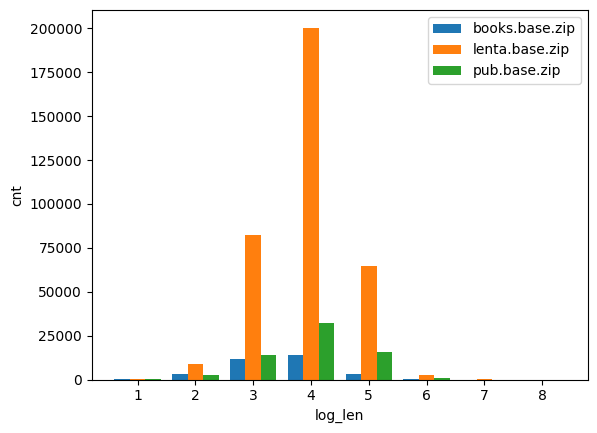

In [5]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

In [6]:
import numpy as np
df = buckets.copy()
df['random'] = np.random.rand(df.shape[0])
df = df.feed(fluq.add_ordering_column(['corpus_id', 'log_len'], 'random'))
df = df.loc[df.order<5000]
df.shape[0]

58292

In [7]:
if False:
    builder.prepare(df)
    builder.featurize()

In [8]:
if False:
    builder.assemble(None, Loc.bundles_path/'alt/tsa-full')
    builder.assemble(1, Loc.bundles_path/'alt/tsa-mini')

In [9]:
from tg.common.ml.batched_training import train_display_test_split

def build_index(bundle):
    path = Loc.bundles_path/'alt'/bundle
    src = pd.read_parquet(path/'src.parquet')
    print(bundle, src.drop_duplicates('sentence_id').shape[0])
    idf = src.loc[src.is_target][['word_id','sentence_id','label']]
    idf.index.name = 'sample_id'
    idf['split'] = train_display_test_split(idf)
    idf.to_parquet(path/'index.parquet')
    
for bundle in ['tsa-full','tsa-mini']:
    build_index(bundle)

tsa-full 137120
tsa-mini 2072


In [10]:
config_mini = BundleConfig(
    [
        Loc.corpus_path/'lenta.base.zip'
    ],
    DictionaryFilterer(tsa_dict),
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
    ],
    Loc.temp_path/'tsa-mini/',
)
builder_mini = BundleBuilder(config_mini)
df_mini = buckets.loc[(buckets.corpus_id=='lenta.base.zip') & (buckets.len==10)].sample(1000)
builder_mini.prepare(df_mini)
builder_mini.featurize()
builder_mini.assemble(None, Loc.bundles_path/'alt/tsa-test')
build_index('tsa-test')

2023-01-15 13:53:46.144720 INFO: Processed 10 words. 2/988
2023-01-15 13:53:46.181540 INFO: Processed 20 words. 2/988
2023-01-15 13:53:46.339192 INFO: Processed 30 words. 3/988
2023-01-15 13:53:46.372656 INFO: Processed 40 words. 3/988
2023-01-15 13:53:46.539350 INFO: Processed 60 words. 4/988
2023-01-15 13:53:46.566036 INFO: Processed 80 words. 4/988
2023-01-15 13:53:46.758835 INFO: Processed 100 words. 5/988
2023-01-15 13:53:46.811403 INFO: Processed 120 words. 5/988
2023-01-15 13:53:47.066299 INFO: Processed 130 words. 7/988
2023-01-15 13:53:47.098898 INFO: Processed 140 words. 7/988
2023-01-15 13:53:47.282289 INFO: Processed 150 words. 8/988
2023-01-15 13:53:47.317133 INFO: Processed 160 words. 8/988
2023-01-15 13:53:47.476227 INFO: Processed 170 words. 9/988
2023-01-15 13:53:47.509011 INFO: Processed 180 words. 9/988
2023-01-15 13:53:47.730160 INFO: Processed 220 words. 10/988
2023-01-15 13:53:47.769693 INFO: Processed 260 words. 10/988
2023-01-15 13:53:47.941682 INFO: Processed 2

2023-01-15 13:54:04.717800 INFO: Processed 2350 words. 99/988
2023-01-15 13:54:04.747592 INFO: Processed 2360 words. 99/988
2023-01-15 13:54:04.929253 INFO: Processed 2380 words. 100/988
2023-01-15 13:54:04.973063 INFO: Processed 2400 words. 100/988
2023-01-15 13:54:05.325687 INFO: Processed 2420 words. 102/988
2023-01-15 13:54:05.383791 INFO: Processed 2440 words. 102/988
2023-01-15 13:54:05.567184 INFO: Processed 2450 words. 103/988
2023-01-15 13:54:05.620285 INFO: Processed 2460 words. 103/988
2023-01-15 13:54:05.794278 INFO: Processed 2480 words. 104/988
2023-01-15 13:54:05.844900 INFO: Processed 2500 words. 104/988
2023-01-15 13:54:06.031230 INFO: Processed 2510 words. 105/988
2023-01-15 13:54:06.072189 INFO: Processed 2520 words. 105/988
2023-01-15 13:54:06.239259 INFO: Processed 2540 words. 106/988
2023-01-15 13:54:06.270963 INFO: Processed 2560 words. 106/988
2023-01-15 13:54:06.439502 INFO: Processed 2570 words. 107/988
2023-01-15 13:54:06.481587 INFO: Processed 2580 words. 10

2023-01-15 13:54:23.557874 INFO: Processed 4420 words. 202/988
2023-01-15 13:54:23.724781 INFO: Processed 4430 words. 203/988
2023-01-15 13:54:23.768357 INFO: Processed 4440 words. 203/988
2023-01-15 13:54:23.959616 INFO: Processed 4450 words. 204/988
2023-01-15 13:54:23.994147 INFO: Processed 4460 words. 204/988
2023-01-15 13:54:24.154292 INFO: Processed 4470 words. 205/988
2023-01-15 13:54:24.198139 INFO: Processed 4480 words. 205/988
2023-01-15 13:54:24.477119 INFO: Processed 4490 words. 207/988
2023-01-15 13:54:24.507355 INFO: Processed 4500 words. 207/988
2023-01-15 13:54:25.215877 INFO: Processed 4510 words. 212/988
2023-01-15 13:54:25.246963 INFO: Processed 4520 words. 212/988
2023-01-15 13:54:25.535186 INFO: Processed 4550 words. 214/988
2023-01-15 13:54:25.563820 INFO: Processed 4580 words. 214/988
2023-01-15 13:54:25.729875 INFO: Processed 4590 words. 215/988
2023-01-15 13:54:25.765462 INFO: Processed 4600 words. 215/988
2023-01-15 13:54:25.942017 INFO: Processed 4610 words. 

2023-01-15 13:54:45.199924 INFO: Processed 6640 words. 301/988
2023-01-15 13:54:45.229607 INFO: Processed 6660 words. 301/988
2023-01-15 13:54:45.389598 INFO: Processed 6670 words. 302/988
2023-01-15 13:54:45.413822 INFO: Processed 6680 words. 302/988
2023-01-15 13:54:46.160276 INFO: Processed 6690 words. 306/988
2023-01-15 13:54:46.195007 INFO: Processed 6700 words. 306/988
2023-01-15 13:54:46.591094 INFO: Processed 6730 words. 307/988
2023-01-15 13:54:46.622181 INFO: Processed 6760 words. 307/988
2023-01-15 13:54:46.897439 INFO: Processed 6780 words. 309/988
2023-01-15 13:54:46.923833 INFO: Processed 6800 words. 309/988
2023-01-15 13:54:47.076381 INFO: Processed 6820 words. 310/988
2023-01-15 13:54:47.105357 INFO: Processed 6840 words. 310/988
2023-01-15 13:54:47.291107 INFO: Processed 6850 words. 311/988
2023-01-15 13:54:47.313495 INFO: Processed 6860 words. 311/988
2023-01-15 13:54:47.468583 INFO: Processed 6870 words. 312/988
2023-01-15 13:54:47.492889 INFO: Processed 6880 words. 

2023-01-15 13:55:06.904623 INFO: Processed 8820 words. 404/988
2023-01-15 13:55:07.152119 INFO: Processed 8830 words. 405/988
2023-01-15 13:55:07.202127 INFO: Processed 8840 words. 405/988
2023-01-15 13:55:07.436560 INFO: Processed 8850 words. 406/988
2023-01-15 13:55:07.487626 INFO: Processed 8860 words. 406/988
2023-01-15 13:55:07.893279 INFO: Processed 8870 words. 408/988
2023-01-15 13:55:07.930557 INFO: Processed 8880 words. 408/988
2023-01-15 13:55:08.112364 INFO: Processed 8890 words. 409/988
2023-01-15 13:55:08.156327 INFO: Processed 8900 words. 409/988
2023-01-15 13:55:08.317436 INFO: Processed 8920 words. 410/988
2023-01-15 13:55:08.361734 INFO: Processed 8940 words. 410/988
2023-01-15 13:55:08.587497 INFO: Processed 8950 words. 411/988
2023-01-15 13:55:08.632507 INFO: Processed 8960 words. 411/988
2023-01-15 13:55:08.811170 INFO: Processed 8980 words. 412/988
2023-01-15 13:55:08.850724 INFO: Processed 9000 words. 412/988
2023-01-15 13:55:09.027508 INFO: Processed 9050 words. 

2023-01-15 13:55:25.327602 INFO: Processed 10840 words. 501/988
2023-01-15 13:55:25.506742 INFO: Processed 10850 words. 502/988
2023-01-15 13:55:25.540794 INFO: Processed 10860 words. 502/988
2023-01-15 13:55:25.719711 INFO: Processed 10870 words. 503/988
2023-01-15 13:55:25.761190 INFO: Processed 10880 words. 503/988
2023-01-15 13:55:26.041437 INFO: Processed 10900 words. 505/988
2023-01-15 13:55:26.092244 INFO: Processed 10920 words. 505/988
2023-01-15 13:55:26.262789 INFO: Processed 10930 words. 506/988
2023-01-15 13:55:26.436442 INFO: Processed 10940 words. 506/988
2023-01-15 13:55:26.627406 INFO: Processed 10950 words. 507/988
2023-01-15 13:55:26.662069 INFO: Processed 10960 words. 507/988
2023-01-15 13:55:26.935741 INFO: Processed 10970 words. 509/988
2023-01-15 13:55:26.972024 INFO: Processed 10980 words. 509/988
2023-01-15 13:55:27.165758 INFO: Processed 10990 words. 510/988
2023-01-15 13:55:27.212475 INFO: Processed 11000 words. 510/988
2023-01-15 13:55:27.379487 INFO: Process

2023-01-15 13:55:44.109234 INFO: Processed 12780 words. 606/988
2023-01-15 13:55:44.281380 INFO: Processed 12800 words. 607/988
2023-01-15 13:55:44.322179 INFO: Processed 12820 words. 607/988
2023-01-15 13:55:44.744101 INFO: Processed 12840 words. 610/988
2023-01-15 13:55:44.774007 INFO: Processed 12860 words. 610/988
2023-01-15 13:55:44.937077 INFO: Processed 12880 words. 611/988
2023-01-15 13:55:44.974062 INFO: Processed 12900 words. 611/988
2023-01-15 13:55:45.497138 INFO: Processed 12910 words. 615/988
2023-01-15 13:55:45.530633 INFO: Processed 12920 words. 615/988
2023-01-15 13:55:45.825018 INFO: Processed 12930 words. 617/988
2023-01-15 13:55:45.861681 INFO: Processed 12940 words. 617/988
2023-01-15 13:55:46.039952 INFO: Processed 12950 words. 618/988
2023-01-15 13:55:46.076040 INFO: Processed 12960 words. 618/988
2023-01-15 13:55:46.244917 INFO: Processed 12970 words. 619/988
2023-01-15 13:55:46.288399 INFO: Processed 12980 words. 619/988
2023-01-15 13:55:46.447267 INFO: Process

2023-01-15 13:56:04.050015 INFO: Processed 14670 words. 699/988
2023-01-15 13:56:04.076665 INFO: Processed 14680 words. 699/988
2023-01-15 13:56:04.238799 INFO: Processed 14700 words. 700/988
2023-01-15 13:56:04.265538 INFO: Processed 14720 words. 700/988
2023-01-15 13:56:04.456820 INFO: Processed 14730 words. 701/988
2023-01-15 13:56:04.496182 INFO: Processed 14740 words. 701/988
2023-01-15 13:56:04.772242 INFO: Processed 14750 words. 702/988
2023-01-15 13:56:04.823228 INFO: Processed 14760 words. 702/988
2023-01-15 13:56:05.720422 INFO: Processed 14780 words. 708/988
2023-01-15 13:56:05.753399 INFO: Processed 14800 words. 708/988
2023-01-15 13:56:06.190055 INFO: Processed 14810 words. 710/988
2023-01-15 13:56:06.218959 INFO: Processed 14820 words. 710/988
2023-01-15 13:56:06.820118 INFO: Processed 14830 words. 712/988
2023-01-15 13:56:06.849244 INFO: Processed 14840 words. 712/988
2023-01-15 13:56:07.109820 INFO: Processed 14850 words. 714/988
2023-01-15 13:56:07.131985 INFO: Process

2023-01-15 13:56:28.521499 INFO: Processed 16660 words. 813/988
2023-01-15 13:56:28.768921 INFO: Processed 16680 words. 814/988
2023-01-15 13:56:28.824744 INFO: Processed 16700 words. 814/988
2023-01-15 13:56:29.032649 INFO: Processed 16710 words. 815/988
2023-01-15 13:56:29.071042 INFO: Processed 16720 words. 815/988
2023-01-15 13:56:29.402444 INFO: Processed 16730 words. 817/988
2023-01-15 13:56:29.428904 INFO: Processed 16740 words. 817/988
2023-01-15 13:56:29.702403 INFO: Processed 16750 words. 819/988
2023-01-15 13:56:29.732638 INFO: Processed 16760 words. 819/988
2023-01-15 13:56:29.894020 INFO: Processed 16780 words. 820/988
2023-01-15 13:56:29.928580 INFO: Processed 16800 words. 820/988
2023-01-15 13:56:30.236811 INFO: Processed 16810 words. 822/988
2023-01-15 13:56:30.262614 INFO: Processed 16820 words. 822/988
2023-01-15 13:56:30.414429 INFO: Processed 16830 words. 823/988
2023-01-15 13:56:30.440344 INFO: Processed 16840 words. 823/988
2023-01-15 13:56:30.613452 INFO: Process

2023-01-15 13:56:42.663472 INFO: Processed 18720 words. 918/988
2023-01-15 13:56:42.682996 INFO: Processed 18740 words. 918/988
2023-01-15 13:56:42.894336 INFO: Processed 18760 words. 920/988
2023-01-15 13:56:42.915323 INFO: Processed 18780 words. 920/988
2023-01-15 13:56:43.032205 INFO: Processed 18790 words. 921/988
2023-01-15 13:56:43.051749 INFO: Processed 18800 words. 921/988
2023-01-15 13:56:43.168517 INFO: Processed 18810 words. 922/988
2023-01-15 13:56:43.188500 INFO: Processed 18820 words. 922/988
2023-01-15 13:56:43.305065 INFO: Processed 18840 words. 923/988
2023-01-15 13:56:43.325939 INFO: Processed 18860 words. 923/988
2023-01-15 13:56:43.441742 INFO: Processed 18870 words. 924/988
2023-01-15 13:56:43.460409 INFO: Processed 18880 words. 924/988
2023-01-15 13:56:43.761817 INFO: Processed 18890 words. 927/988
2023-01-15 13:56:43.783606 INFO: Processed 18900 words. 927/988
2023-01-15 13:56:43.905861 INFO: Processed 18910 words. 928/988
2023-01-15 13:56:43.925690 INFO: Process

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: build_index() missing 1 required positional argument: 'split'

In [ ]:
db = DataBundle.load(Loc.bundles_path/'alt/tsa-test')
db.save_as_zip(Loc.bundles_path/'alt/tsa-test.zip')

In [ ]:
db.src